In [2]:
import os
import numpy as np
import pandas as pd
import pydicom
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
import torchvision
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
import json
from PIL import Image
from torchvision.utils import save_image
import glob

## Data preprocessing

In [3]:
train_db = pd.read_csv("/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv")
class_info = pd.read_csv("/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_detailed_class_info.csv")

In [4]:
train_db.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [5]:
train_db["Target"].value_counts()

Target
0    20672
1     9555
Name: count, dtype: int64

In [6]:
train_db=train_db.groupby('patientId')
train_db.head(10)

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
...,...,...,...,...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0
30224,c1f6b555-2eb1-4231-98f6-50a963976431,NaN,NaN,NaN,NaN,0
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1


In [7]:
images=[]
bboxes = []
labels = []
patient_ids = []
for patient_id,group in tqdm(train_db):
    file=os.path.join('/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images',patient_id + ".dcm")
    dicom=pydicom.dcmread(file)
    img=dicom.pixel_array
    image=cv2.resize(img,(224,224)).astype(np.float32) / 255.0
    images.append(image)

    boxes=[]
    for _,row in group.iterrows():
        if row["Target"]==1:
            x_scale= 224/img.shape[1]
            y_scale= 224/img.shape[0]
            x1=row["x"]* x_scale
            y1=row["y"]* y_scale
            x2=x1+row["width"]* x_scale
            y2=y1+row["height"]* y_scale
            boxes.append([x1,y1,x2,y2])
    bboxes.append(boxes)
    if len(boxes) > 0:
        labels.append([1] * len(boxes))  # one label per box
    else:
        labels.append([]) 
    patient_ids.append(patient_id)
    
    

100%|██████████| 26684/26684 [05:42<00:00, 77.96it/s]


In [8]:
# Check the first 5 samples
for i in range(5):
    print(f"Image {i} shape: {images[i].shape}")
    print(f"Boxes: {bboxes[i]}")
    print(f"Labels: {labels[i]}")


Image 0 shape: (224, 224)
Boxes: []
Labels: []
Image 1 shape: (224, 224)
Boxes: []
Labels: []
Image 2 shape: (224, 224)
Boxes: [[69.125, 69.5625, 106.3125, 174.125], [144.375, 82.03125, 176.3125, 169.96875]]
Labels: [1, 1]
Image 3 shape: (224, 224)
Boxes: [[124.6875, 61.6875, 183.53125, 151.15625], [18.15625, 49.65625, 82.90625, 145.46875]]
Labels: [1, 1]
Image 4 shape: (224, 224)
Boxes: [[14.4375, 35.0, 96.03125, 168.0], [120.75, 35.875, 203.0, 183.75]]
Labels: [1, 1]


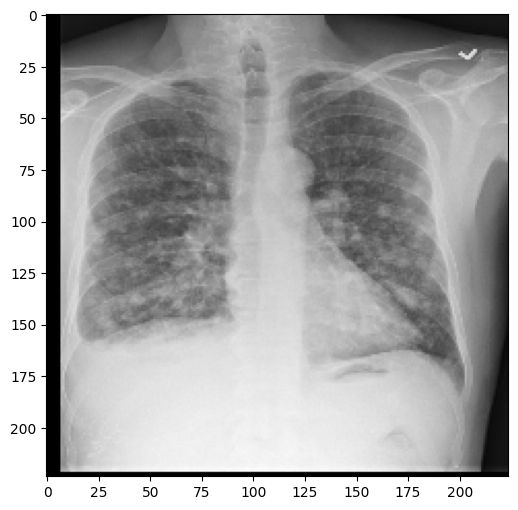

In [9]:
plt.figure(figsize=(6,6))
plt.imshow(images[4], cmap='gray')


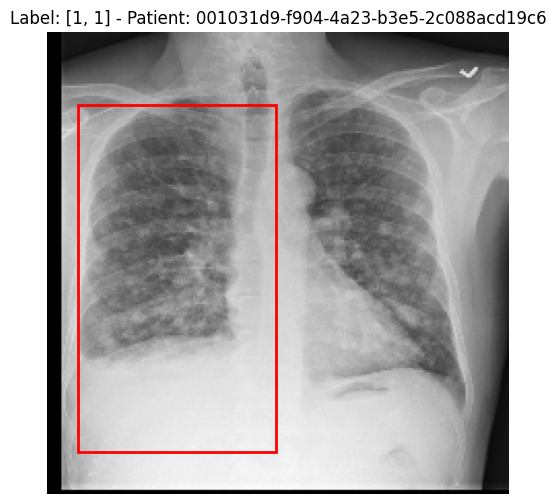

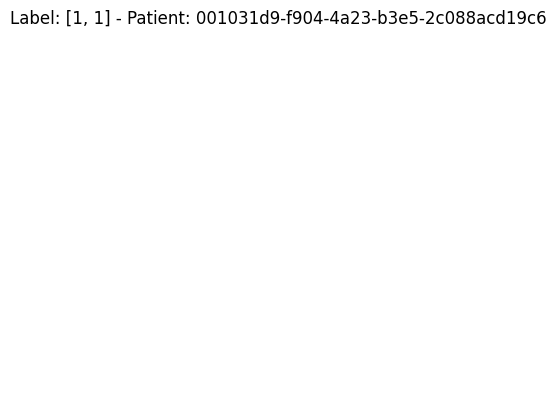

In [10]:
plt.figure(figsize=(6,6))
plt.imshow(images[4], cmap='gray')

for box in bboxes[4]:
    x, y, w, h = box
    rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)

    plt.title(f"Label: {labels[4]} - Patient: {patient_ids[4]}")
    plt.axis("off")
    plt.show()

In [11]:
class MedicalDataset(Dataset):
    def __init__(self,images,bboxes,labels,patient_ids):
        self.images=images
        self.bboxes=bboxes
        self.labels=labels
        self.patient_ids=patient_ids

    def __getitem__(self,idx):
        image=self.images[idx]
        boxes=self.bboxes[idx]
        labels=self.labels[idx]
        
        image=torch.tensor(image,dtype=torch.float32).unsqueeze(0)
        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)  # Empty box, shape [0, 4]
            labels = torch.zeros(0, dtype=torch.int64)  # No labels for empty boxes
        else:
            boxes = torch.tensor(boxes, dtype=torch.float32)
            labels = torch.tensor(labels, dtype=torch.int64)
        
        target = {
            'boxes': boxes,
            'labels': labels}
        
        return image, target

        
    def __len__(self):
        return len(self.images)
        
        

In [12]:
positive_indices = [i for i, l in enumerate(labels) if len(l) > 0]
negative_indices = [i for i, l in enumerate(labels) if len(l) == 0]

In [13]:
import random
random.seed(42)  # For reproducibility
neg_indices = random.sample(negative_indices, len(positive_indices))


In [14]:
# Positive samples
pos_images = [images[i] for i in positive_indices]
pos_bboxes = [bboxes[i] for i in positive_indices]
pos_labels = [labels[i] for i in positive_indices]
pos_ids = [patient_ids[i] for i in positive_indices]

# Negative samples
neg_images = [images[i] for i in neg_indices]
neg_bboxes = [bboxes[i] for i in neg_indices]
neg_labels = [labels[i] for i in neg_indices]
neg_ids = [patient_ids[i] for i in neg_indices]


In [15]:
from sklearn.model_selection import train_test_split

# 1. Split positives into train/val
train_pos_images, val_pos_images, train_pos_bboxes, val_pos_bboxes, train_pos_labels, val_pos_labels, train_pos_ids, val_pos_ids = train_test_split(
    pos_images, pos_bboxes, pos_labels, pos_ids, test_size=0.2, random_state=42
)

# 2. Split negatives into fine-tune and test
train_neg_images, neg_test_images, train_neg_bboxes, neg_test_bboxes, train_neg_labels, neg_test_labels, train_neg_ids, neg_test_ids = train_test_split(
    neg_images, neg_bboxes, neg_labels, neg_ids, test_size=0.2, random_state=42
)



In [16]:
# Stage 1: Train
train_images = train_pos_images+train_neg_images
train_bboxes = train_pos_bboxes+train_neg_bboxes
train_labels = train_pos_labels+train_neg_labels
train_ids = train_pos_ids+train_neg_ids


# Stage 2: Final Test
test_images = neg_test_images + val_pos_images
test_bboxes = neg_test_bboxes + val_pos_bboxes
test_labels = neg_test_labels + val_pos_labels
test_ids = neg_test_ids + val_pos_ids


In [17]:
from torch.utils.data import WeightedRandomSampler
train_weights = [1 if label == 0 else 15 for label in train_labels]
train_sampler = WeightedRandomSampler(train_weights, num_samples=len(train_labels), replacement=True)
train_dataset = MedicalDataset(train_images, train_bboxes, train_labels, train_ids)
test_class_weights = [1 if label == 0 else 15 for label in test_labels]
test_sampler = WeightedRandomSampler(test_class_weights, num_samples=len(test_labels), replacement=True)
test_dataset = MedicalDataset(test_images, test_bboxes, test_labels, test_ids)

In [18]:
train_dataloader = DataLoader(train_dataset, batch_size=3,sampler=train_sampler,shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

test_dataloader = DataLoader(test_dataset, batch_size=4,sampler=test_sampler,shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

## Model Training:

In [19]:
def build_retina():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=True)
    
    num_classes=2
    
    in_channels=model.head.classification_head.conv[0][0].in_channels
    num_anchors=model.head.classification_head.num_anchors
    
    model.head.classification_head=torchvision.models.detection.retinanet.RetinaNetClassificationHead(
    in_channels=in_channels,
    num_anchors=num_anchors,
    num_classes=num_classes)
    
    model = torch.nn.DataParallel(model)
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    lr_scheduler=torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)
    return model,optimizer,lr_scheduler

In [ ]:
model,optimizer,lr_scheduler=build_retina()

In [28]:
torch.cuda.device_count()

0

In [20]:
def build_fast_rcnn():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    num_classes = 2  # 1 class (pneumonia) + background
    
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
    in_features, num_classes)
    
    model = torch.nn.DataParallel(model)
    model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    return model,optimizer,lr_scheduler


In [ ]:
model,optimizer,lr_scheduler=build_fast_rcnn()

In [27]:
# Early stopping
best_val_loss = float('inf')
patience = 3
epochs_without_improvement = 0

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    for images, targets in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()

        optimizer.step()
        running_loss += losses.item()

    avg_train_loss = running_loss / len(train_dataloader)
    print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss}")

    # Validation
    model.train()
    with torch.no_grad():
        running_val_loss = 0
        for images, targets in test_dataloader:
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            loss_dict = model(images, targets)
            val_loss = sum(loss for loss in loss_dict.values())
            running_val_loss += val_loss.item()

        avg_val_loss = running_val_loss / len(test_dataloader)
        print(f"Epoch {epoch+1} - Val Loss: {avg_val_loss}")

        # Early stopping condition
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_without_improvement = 0
            # Save best model
            torch.save(model.state_dict(), f"best_f_model_epoch_{epoch+1}.pth")
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print("Early stopping...")
            break

    lr_scheduler.step()

Epoch 1/10: 100%|██████████| 3206/3206 [17:08<00:00,  3.12it/s]


Epoch 1 - Train Loss: 0.16403734584652552
Epoch 1 - Val Loss: 0.16581821265372626


Epoch 2/10: 100%|██████████| 3206/3206 [17:08<00:00,  3.12it/s]


Epoch 2 - Train Loss: 0.15308839760673743
Epoch 2 - Val Loss: 0.15673219103382394


Epoch 3/10: 100%|██████████| 3206/3206 [17:08<00:00,  3.12it/s]


Epoch 3 - Train Loss: 0.14836847811407688
Epoch 3 - Val Loss: 0.15713983845848828


Epoch 4/10: 100%|██████████| 3206/3206 [17:09<00:00,  3.11it/s]


Epoch 4 - Train Loss: 0.13170989278340955
Epoch 4 - Val Loss: 0.15860324054436778


Epoch 5/10:   1%|▏         | 45/3206 [00:14<16:57,  3.11it/s]


KeyboardInterrupt: 

## Model testing

In [21]:
retina,_,_=build_retina()
retina.load_state_dict(torch.load("/kaggle/input/retinanet_custom/pytorch/default/2/best_model_epoch_7.pth", weights_only=True,map_location=torch.device('cpu')))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth
100%|██████████| 130M/130M [00:00<00:00, 207MB/s] 


<All keys matched successfully>

In [22]:
frcnn,_,_=build_fast_rcnn()
frcnn.load_state_dict(torch.load("/kaggle/input/fastrcnn/pytorch/default/1/best_f_model_epoch_2.pth", weights_only=True,map_location=torch.device('cpu')))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 201MB/s] 


<All keys matched successfully>

In [26]:
# Load the best model
#model.load_state_dict(torch.load("/kaggle/working/best_model_epoch_1.pth", weights_only=True))
model=retina
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from sklearn.metrics import roc_auc_score, roc_curve,confusion_matrix

all_scores = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, targets in test_dataloader:
        images = [img.to(device) for img in images]
        outputs = model(images)
        
        for output, target in zip(outputs, targets):
            # Predicted score: max confidence of predicted boxes (or 0 if none)
            scores = output['scores'].cpu().numpy()
            pred_score = max(scores) if len(scores) > 0 else 0.0
            all_scores.append(pred_score)

            # Ground truth: 1 if any bbox exists, else 0
            gt_label = 1 if len(target['boxes']) > 0 else 0
            all_labels.append(gt_label)


In [27]:
# ensemble validation
all_scores = []
all_labels = []

retina.eval()  # RetinaNet
frcnn.eval()  # Faster R-CNN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
with torch.no_grad():
    for images, targets in tqdm(test_dataloader):
        images = [img.to(device) for img in images]

        outputs1 = retina(images)
        outputs2 = frcnn(images)

        for out1, out2, target in zip(outputs1, outputs2, targets):
            # Get max score from each model
            scores1 = out1['scores'].cpu().numpy()
            scores2 = out2['scores'].cpu().numpy()

            score1 = max(scores1) if len(scores1) > 0 else 0.0
            score2 = max(scores2) if len(scores2) > 0 else 0.0

            # Ensemble score = average of the two
            ensemble_score = (score1 + score2) / 2.0
            all_scores.append(ensemble_score)

            # Ground truth: 1 if any box exists
            label = 1 if len(target['boxes']) > 0 else 0
            all_labels.append(label)


100%|██████████| 602/602 [03:31<00:00,  2.85it/s]


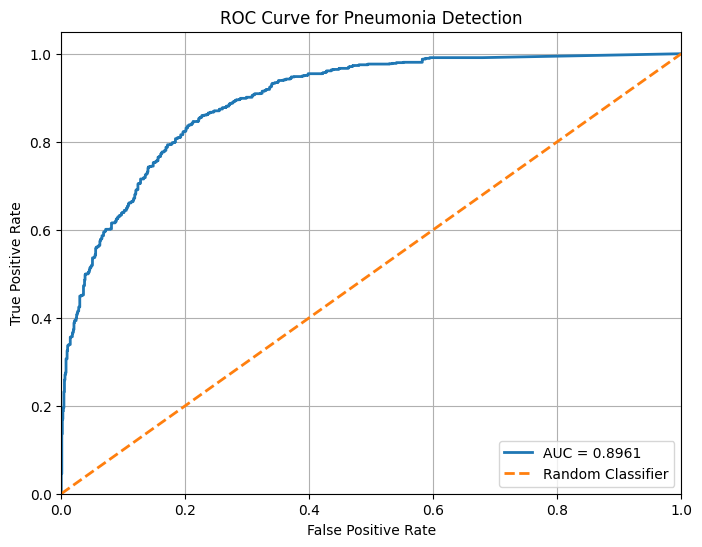

In [27]:
from sklearn.metrics import roc_auc_score, roc_curve,confusion_matrix

import matplotlib.pyplot as plt
fpr, tpr, _ = roc_curve(all_labels, all_scores)
auc_score = roc_auc_score(all_labels, all_scores)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], lw=2, linestyle='--', label="Random Classifier")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Pneumonia Detection")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()




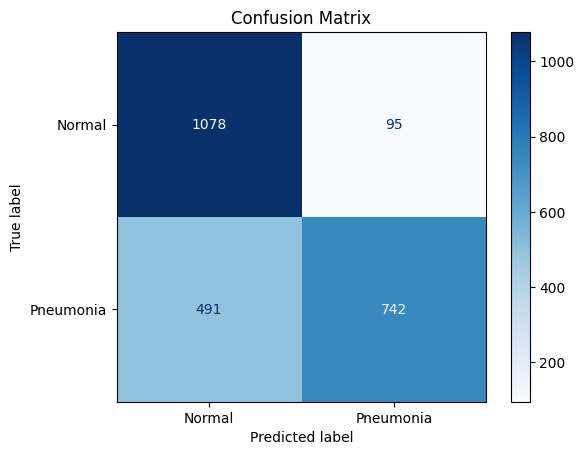

True Positives:  742
False Positives: 95
True Negatives:  1078
False Negatives: 491


In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Binarize scores using a threshold (you can tune this)
threshold = 0.2
predicted_labels = [1 if score >= threshold else 0 for score in all_scores]

# 2. Create the confusion matrix
cm = confusion_matrix(all_labels, predicted_labels)

# 3. Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Pneumonia"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Optional: print TP, FP, FN, TN manually
tn, fp, fn, tp = cm.ravel()
print(f"True Positives:  {tp}")
print(f"False Positives: {fp}")
print(f"True Negatives:  {tn}")
print(f"False Negatives: {fn}")


In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(all_labels,predicted_labels)
recall = recall_score(all_labels, predicted_labels)
f1 = f1_score(all_labels, predicted_labels)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Precision: 0.6034
Recall: 0.9900
F1 Score: 0.7498


In [ ]:
from collections import Counter
print(Counter(all_labels)) 

In [23]:
import pydicom
import numpy as np
from torchvision.transforms import functional as TF
from PIL import Image
import torch

def load_dicom_as_tensor(dicom_path):
    dicom = pydicom.dcmread(dicom_path)
    image = dicom.pixel_array.astype(np.float32)

    # Normalize to [0, 255]
    image -= image.min()
    image /= image.max()
    image *= 255.0

    image = Image.fromarray(image).convert("RGB")  # Convert to 3 channels
    image_tensor = TF.to_tensor(image)  # [C, H, W], float32
    return image_tensor

def predict_dicom(model, dicom_path, device="cuda"):
    model.eval()
    image_tensor = load_dicom_as_tensor(dicom_path).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)[0]

    boxes = output['boxes'].cpu().numpy()
    scores = output['scores'].cpu().numpy()

    preds = []
    for box, score in zip(boxes, scores):
        if score > 0.5:  # confidence threshold
            x_min, y_min, x_max, y_max = box
            w = x_max - x_min
            h = y_max - y_min
            preds.append(f"{score:.4f} {x_min:.1f} {y_min:.1f} {w:.1f} {h:.1f}")
    return " ".join(preds)


In [32]:
import os
import pandas as pd

# Setup paths
dicom_folder = "/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_test_images"
dicom_files = [f for f in os.listdir(dicom_folder) if f.endswith(".dcm")]

submission_data = []

for filename in  tqdm(dicom_files, desc="Predicting"):
    dicom_path = os.path.join(dicom_folder, filename)
    patient_id = filename.replace(".dcm", "")
    pred_str = predict_dicom(retina, dicom_path, device="cpu")
    submission_data.append({
        "patientId": patient_id,
        "PredictionString": pred_str
    })

submission_df = pd.DataFrame(submission_data)
submission_df.to_csv("/kaggle/working/submission.csv", index=False)


Predicting: 100%|██████████| 3000/3000 [03:30<00:00, 14.22it/s]


### Testing using ensemble:

In [24]:
def predict_dicom_ensemble(models, dicom_path, device="cuda", conf_thresh=0.5, iou_thresh=0.5):
    image_tensor = load_dicom_as_tensor(dicom_path).unsqueeze(0).to(device)

    all_boxes = []
    all_scores = []

    for model in models:
        model.eval()
        with torch.no_grad():
            output = model(image_tensor)[0]
        
        boxes = output['boxes']
        scores = output['scores']

        mask = scores > conf_thresh
        all_boxes.append(boxes[mask])
        all_scores.append(scores[mask])
    
    # Concatenate all model predictions
    if not all_boxes:
        return ""
    
    all_boxes = torch.cat(all_boxes, dim=0)
    all_scores = torch.cat(all_scores, dim=0)

    # Apply NMS to merge overlapping predictions from different models
    keep = ops.nms(all_boxes, all_scores, iou_thresh)
    final_boxes = all_boxes[keep].cpu().numpy()
    final_scores = all_scores[keep].cpu().numpy()

    preds = []
    for box, score in zip(final_boxes, final_scores):
        x_min, y_min, x_max, y_max = box
        w = x_max - x_min
        h = y_max - y_min
        preds.append(f"{score:.4f} {x_min:.1f} {y_min:.1f} {w:.1f} {h:.1f}")
    
    return " ".join(preds)

In [26]:
import torchvision.ops as ops
import os
import pandas as pd

# Setup paths
dicom_folder = "/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_test_images"
dicom_files = [f for f in os.listdir(dicom_folder) if f.endswith(".dcm")]

submission_data = []

for filename in  tqdm(dicom_files, desc="Predicting"):
    dicom_path = os.path.join(dicom_folder, filename)
    patient_id = filename.replace(".dcm", "")
    pred_str = predict_dicom_ensemble([retina,frcnn], dicom_path, device="cpu")
    submission_data.append({
        "patientId": patient_id,
        "PredictionString": pred_str
    })

submission_df = pd.DataFrame(submission_data)
submission_df.to_csv("/kaggle/working/submission.csv", index=False)


Predicting: 100%|██████████| 3000/3000 [07:11<00:00,  6.95it/s]


## Feedback loop

In [ ]:
model_path = "/kaggle/input/retinanet_custom/pytorch/default/1/best_model_epoch_5.pth"
feedback_dir = "/kaggle/working/live_feedback"
os.makedirs(feedback_dir, exist_ok=True)

In [ ]:
model.load_state_dict(torch.load(model_path))
model.eval()


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [ ]:
def run_inference(image_path):
    image = Image.open(image_path).convert("L")
    tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(tensor)[0]

    return output, tensor.squeeze(0).cpu()
    
def request_doctor_feedback(image_tensor, output, image_name):
    # Display image
    save_image(image_tensor, os.path.join(FEEDBACK_DIR, image_name))

    print(f"Prediction saved as: {image_name}")
    print("Doctor: please review the image and provide corrected boxes.")
    print("Format: [[x1, y1, x2, y2], ...] or leave blank if no pneumonia")

    # Ask doctor to provide corrected boxes
    doctor_boxes = input("Enter corrected boxes (JSON format): ")

    try:
        doctor_boxes = json.loads(doctor_boxes)
    except:
        doctor_boxes = []

    feedback = {
        "image_file": image_name,
        "predicted_boxes": output["boxes"].cpu().tolist(),
        "scores": output["scores"].cpu().tolist(),
        "doctor_verified_boxes": doctor_boxes
    }

    with open(os.path.join(FEEDBACK_DIR, image_name.replace(".png", ".json")), "w") as f:
        json.dump(feedback, f, indent=2)

    print("✔️ Feedback saved.")

def check_and_finetune_model(threshold=100):
    json_files = glob.glob(os.path.join(FEEDBACK_DIR, "*.json"))
    if len(json_files) < threshold:
        print(f"Only {len(json_files)}/{threshold} feedbacks. Not retraining yet.")
        return

    print("🔁 Starting fine-tuning...")

    corrected_images, corrected_boxes, corrected_labels, corrected_ids = [], [], [], []
    for jfile in json_files:
        with open(jfile, "r") as f:
            data = json.load(f)

        if not data["doctor_verified_boxes"]:
            continue

        image_path = os.path.join(FEEDBACK_DIR, data["image_file"])
        img = Image.open(image_path).convert("L")
        img_tensor = transform(img)
        corrected_images.append(img_tensor)
        corrected_boxes.append(data["doctor_verified_boxes"])
        corrected_labels.append([1] * len(data["doctor_verified_boxes"]))
        corrected_ids.append(data["image_file"].split(".")[0])

    # Build dataset and dataloader
    feedback_dataset = MedicalDataset(corrected_images, corrected_boxes, corrected_labels, corrected_ids)
    feedback_loader = DataLoader(feedback_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

    # Fine-tune model
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
    model.train()

    for epoch in range(2):  # small fine-tune
        for images, targets in feedback_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            optimizer.zero_grad()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            losses.backward()
            optimizer.step()

        print(f"Epoch {epoch+1} done.")

    # Save updated model
    torch.save(model.state_dict(), MODEL_PATH)
    print("✅ Fine-tuned model saved.")


In [ ]:
def process_doctor_input(image_path):
    image_name = os.path.basename(image_path).replace(".dcm", ".png")
    output, img_tensor = run_inference(image_path)
    request_doctor_feedback(img_tensor, output, image_name)
    check_and_finetune_model(threshold=100)